### 1. Laboratorio clase 7: Introducción y contexto


En este laboratorio exploraremos la técnica de ajuste de parámetros conocida como **LoRA (Low-Rank Adaptation)**, que permite adaptar modelos grandes sin necesidad de actualizar todos sus parámetros. La idea central de LoRA es congelar los pesos originales del modelo y entrenar únicamente un conjunto de capas adicionales que modifican el comportamiento del modelo de manera eficiente y controlada.

Este laboratorio tiene los siguientes objetivos:

- Comprender los fundamentos matemáticos y computacionales de LoRA.
- Implementar manualmente una versión simplificada de LoRA sobre una capa lineal congelada.
- Visualizar la pérdida de entrenamiento y las matrices de pesos para entender el efecto de la adaptación.
- Aplicar LoRA en un modelo preentrenado real (`flan-t5-small`) para una tarea de resumen automático.
- Comparar el rendimiento de LoRA contra el ajuste completo del modelo en términos de calidad del resumen generado.

### 2. LoRA hecha en casa

En esta sección construiremos una versión simplificada de LoRA desde cero, utilizando PyTorch. Simularemos un escenario en el que tenemos una **capa lineal preentrenada** cuyos pesos están congelados (es decir, no se pueden modificar).

Para adaptar esta capa a un nuevo conjunto de datos, introduciremos un módulo adicional que aprende una **matriz de actualización de bajo rango** usando dos capas lineales (A y B). Este módulo se entrena mientras la capa original permanece intacta.

Esta implementación nos permitirá entender:
- Cómo se construye la arquitectura de LoRA manualmente.
- Cómo se entrena solo la parte adaptable del modelo.
- Qué papel juegan los hiperparámetros `r` (rango) y `alpha` (escalamiento).

In [1]:
# Importamos librerías necesarias

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
# Simulamos datos de entrenamiento y definimos clases para llevar a cabo el fine-tuning

x = torch.randn(64, 64) 
target = torch.randn(64, 32) 

class FrozenLinear(nn.Module):
    """
    Capa lineal con pesos y bias congelados (no entrenables).

    Args:
        in_features (int): Número de características de entrada.
        out_features (int): Número de características de salida.
    """
    def __init__(self, in_features, out_features):
        """
        Inicializa la capa FrozenLinear con pesos aleatorios y bias en cero.

        Args:
            in_features (int): Número de características de entrada.
            out_features (int): Número de características de salida.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.weight.requires_grad = False
        self.bias.requires_grad = False

    def forward(self, x):
        """
        Realiza la pasada hacia adelante usando los pesos y bias congelados.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Salida de la capa lineal.
        """
        return F.linear(x, self.weight, self.bias)

class LoRALinear(nn.Module):
    """
    Capa lineal con adaptación LoRA sobre una capa congelada.

    Args:
        frozen_layer (FrozenLinear): Capa lineal congelada.
        r (int): Rango de la descomposición de LoRA.
        alpha (int): Escalado de LoRA.
    """
    def __init__(self, frozen_layer, r=4, alpha=8):
        """
        Inicializa la capa LoRALinear con matrices A y B entrenables.

        Args:
            frozen_layer (FrozenLinear): Capa lineal congelada.
            r (int): Rango de la descomposición de LoRA.
            alpha (int): Escalado de LoRA.
        """
        super().__init__()
        self.frozen = frozen_layer
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        in_features = frozen_layer.weight.shape[1]
        out_features = frozen_layer.weight.shape[0]

        self.A = nn.Linear(in_features, r, bias=False)
        self.B = nn.Linear(r, out_features, bias=False)

        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante sumando la salida congelada y la adaptación LoRA.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Salida de la capa LoRA.
        """
        return self.frozen(x) + self.scaling * self.B(self.A(x))

In [3]:
# Definimos capas congeladas y LoRA, optimizador y hacemos fine-tuning

frozen_layer = FrozenLinear(64, 32)
lora_layer = LoRALinear(frozen_layer)
optimizer = torch.optim.Adam(lora_layer.parameters(), lr=1e-2)

losses = []
for epoch in range(100):
    optimizer.zero_grad()
    output = lora_layer(x)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

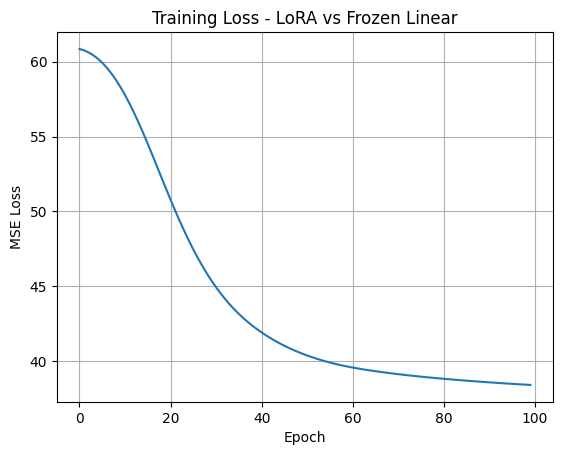

In [4]:
# Visualizamos la pérdida durante el fine-tuning

plt.plot(losses)
plt.title("Training Loss - LoRA vs Frozen Linear")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

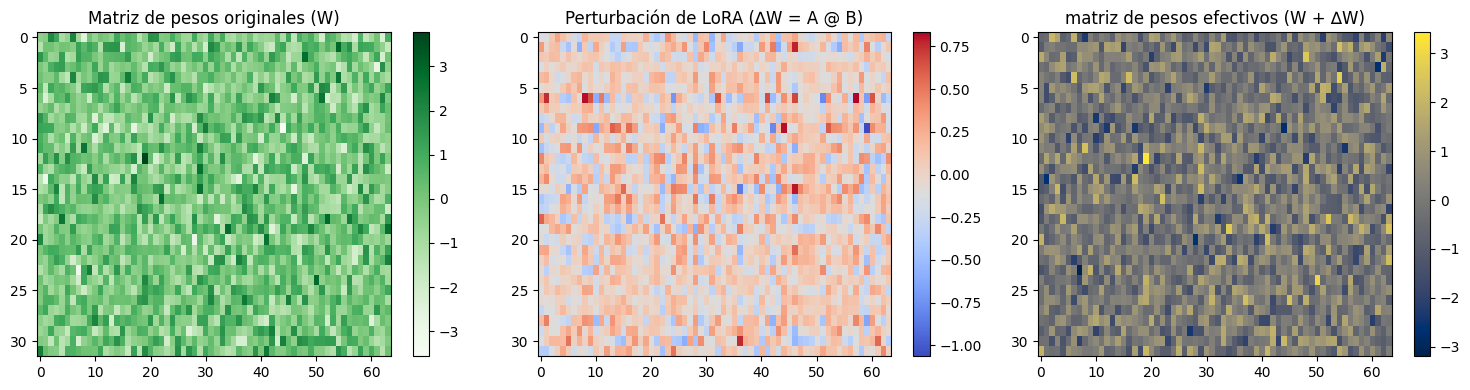

In [5]:
# Visualización de pesos antes y después del fine-tuning

with torch.no_grad():
    A = lora_layer.A.weight  
    B = lora_layer.B.weight  
    delta_W = (A.T @ B.T).T  

    W_frozen = frozen_layer.weight.detach()
    W_effective = W_frozen + delta_W

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(W_frozen.numpy(), aspect='auto', cmap='Greens')
plt.title("Matriz de pesos originales (W)")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(delta_W.numpy(), aspect='auto', cmap='coolwarm')
plt.title("Perturbación de LoRA (∆W = A @ B)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(W_effective.numpy(), aspect='auto', cmap='cividis')
plt.title("matriz de pesos efectivos (W + ∆W)")
plt.colorbar()

plt.tight_layout()
plt.show()



### 3. Generación de resúmenes: Modelo pre-entrenado vs modelos con fine-tuning

Ahora vamos a algo más realista. Vamos a utilizar un modelo preentrenado: **`google/flan-t5-small`**, diseñado para tareas de generación de texto.

En esta sección:
- Cargaremos y preprocesaremos el conjunto de datos `XSum` para tareas de resumen automático.
- Evaluaremos la capacidad del modelo original (zero-shot).
- Aplicaremos **LoRA** sobre el modelo T5 utilizando la librería `peft` de Hugging Face.
- Entrenaremos solo los adaptadores LoRA, manteniendo el resto del modelo congelado.

Esta parte es esencial para ver cómo se aplica LoRA en la práctica con un modelo grande y un conjunto de datos real. Además, compararemos el rendimiento del modelo pre-entrenado con diferentes fine-tunings.

In [6]:
# Importamos librerías necesarias

from datasets import load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType
import pandas as pd

/Users/fdiazja/trial_reqs_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0522 18:19:51.339000 5627 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [7]:
# Importamos modelo pre-entrenado, tokenizador, dataset y procesamos los datos

model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_full = T5ForConditionalGeneration.from_pretrained(model_id)
model_full = model_full.to("cpu")

dataset = load_dataset("xsum")
dataset = dataset["train"].select(range(300)).train_test_split(test_size=0.1)

max_input_length = 128
max_target_length = 32

def preprocess(example):
    """
    Preprocesa un ejemplo del dataset para el modelo T5, agregando el prompt y tokenizando.

    Args:
        example (dict): Diccionario con las claves 'document' y 'summary'.

    Returns:
        dict: Diccionario con los input_ids y labels tokenizados.
    """
    inputs = ["summarize: " + doc for doc in example["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["summary"], max_length=max_target_length, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)

/Users/fdiazja/trial_reqs_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/fdiazja/trial_reqs_env/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Map:   0%|          | 0/270 [00:00<?, ? examples/s]/Users/fdiazja/trial_reqs_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will

In [8]:
# Generamos texto completo y lo tokenizamos

sample = dataset["test"][0]["document"]
ref_summary = dataset["test"][0]["summary"]
input_ids = tokenizer("summarize: " + sample, return_tensors="pt", truncation=True, max_length=512).input_ids.to("cpu")
output_full = model_full.generate(input_ids, max_length=128)
summary_full = tokenizer.decode(output_full[0], skip_special_tokens=True)

print("\nTexto original:\n", sample[:565])


Texto original:
 The Doncaster Central MP was one of three members to be chosen in a secret ballot, succeeding Natascha Engel who lost her seat at the election.
Labour's Lindsay Hoyle topped the ballot and was re-elected as chairman of ways and means. In that role, he will preside over Budget debates.
Tory Eleanor Laing was also re-elected as another deputy to John Bercow.
The Commons Speaker, who has held the role since 2009, was himself re-elected without a formal vote two weeks ago.
As he first stood for the Commons as a Conservative MP, Mr Bercow's deputies must be compri


In [9]:
# Generamos resumen usando el modelo original
model_zero = T5ForConditionalGeneration.from_pretrained(model_id).to("cpu")
input_ids_zero = tokenizer("summarize: " + sample, return_tensors="pt").input_ids.to("cpu")
output_zero = model_zero.generate(input_ids_zero, max_length=64)
summary_zero = tokenizer.decode(output_zero[0], skip_special_tokens=True)

print("\nResumen generado (Zero-shot, modelo preentrenado sin fine-tuning):\n", summary_zero)


Resumen generado (Zero-shot, modelo preentrenado sin fine-tuning):
 The Conservatives have re-elected Deputy Speaker of the Commons in the first election in a row.


In [10]:
# Realizamos fine-tuning cmpleto del modelo pre-entrenado con el fin de mejorar la generación de resúmenes

args_full = Seq2SeqTrainingArguments(
    output_dir="./flan_full",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
    logging_dir=None
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_full)

trainer_full = Seq2SeqTrainer(
    model=model_full,
    args=args_full,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer_full.train()

  0%|          | 0/405 [00:00<?, ?it/s]/Users/fdiazja/trial_reqs_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  3%|▎         | 11/405 [00:01<00:52,  7.48it/s]

{'loss': 10.8805, 'grad_norm': 12.730035781860352, 'learning_rate': 4.876543209876544e-05, 'epoch': 0.07}


  5%|▌         | 21/405 [00:03<00:49,  7.76it/s]

{'loss': 7.5613, 'grad_norm': 6.170865535736084, 'learning_rate': 4.7530864197530866e-05, 'epoch': 0.15}


  8%|▊         | 31/405 [00:04<00:48,  7.70it/s]

{'loss': 6.7545, 'grad_norm': 16.52354621887207, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}


 10%|█         | 41/405 [00:05<00:48,  7.51it/s]

{'loss': 5.1598, 'grad_norm': 27.235820770263672, 'learning_rate': 4.506172839506173e-05, 'epoch': 0.3}


 13%|█▎        | 51/405 [00:07<00:46,  7.66it/s]

{'loss': 7.3569, 'grad_norm': 12.812726020812988, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.37}


 15%|█▌        | 61/405 [00:08<00:44,  7.80it/s]

{'loss': 6.6307, 'grad_norm': 25.279823303222656, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}


 18%|█▊        | 71/405 [00:09<00:43,  7.74it/s]

{'loss': 6.7209, 'grad_norm': 16.357820510864258, 'learning_rate': 4.135802469135803e-05, 'epoch': 0.52}


 20%|██        | 81/405 [00:10<00:41,  7.76it/s]

{'loss': 5.0206, 'grad_norm': 33.314430236816406, 'learning_rate': 4.012345679012346e-05, 'epoch': 0.59}


 22%|██▏       | 91/405 [00:12<00:40,  7.69it/s]

{'loss': 5.3189, 'grad_norm': 17.031137466430664, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}


 25%|██▍       | 101/405 [00:13<00:39,  7.73it/s]

{'loss': 5.9254, 'grad_norm': 30.187822341918945, 'learning_rate': 3.7654320987654326e-05, 'epoch': 0.74}


 27%|██▋       | 111/405 [00:14<00:38,  7.68it/s]

{'loss': 4.8947, 'grad_norm': 9.625133514404297, 'learning_rate': 3.6419753086419754e-05, 'epoch': 0.81}


 30%|██▉       | 121/405 [00:16<00:37,  7.65it/s]

{'loss': 4.7889, 'grad_norm': 34.28499984741211, 'learning_rate': 3.518518518518519e-05, 'epoch': 0.89}


 32%|███▏      | 131/405 [00:17<00:36,  7.61it/s]

{'loss': 5.3326, 'grad_norm': 7.983232021331787, 'learning_rate': 3.395061728395062e-05, 'epoch': 0.96}


                                                 
 34%|███▎      | 136/405 [00:18<01:07,  3.97it/s]

{'eval_loss': 3.5894320011138916, 'eval_runtime': 0.403, 'eval_samples_per_second': 74.439, 'eval_steps_per_second': 37.219, 'epoch': 1.0}


 35%|███▍      | 141/405 [00:19<00:40,  6.60it/s]

{'loss': 4.0985, 'grad_norm': 5.871433734893799, 'learning_rate': 3.271604938271605e-05, 'epoch': 1.04}


 37%|███▋      | 151/405 [00:20<00:33,  7.57it/s]

{'loss': 4.1004, 'grad_norm': 8.88196086883545, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}


 40%|███▉      | 161/405 [00:21<00:31,  7.66it/s]

{'loss': 3.9693, 'grad_norm': 7.498966693878174, 'learning_rate': 3.0246913580246916e-05, 'epoch': 1.19}


 42%|████▏     | 171/405 [00:23<00:30,  7.57it/s]

{'loss': 4.1998, 'grad_norm': 11.600198745727539, 'learning_rate': 2.9012345679012347e-05, 'epoch': 1.26}


 45%|████▍     | 181/405 [00:24<00:29,  7.65it/s]

{'loss': 3.9242, 'grad_norm': 11.616741180419922, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


 47%|████▋     | 191/405 [00:25<00:28,  7.61it/s]

{'loss': 3.9827, 'grad_norm': 5.939660549163818, 'learning_rate': 2.654320987654321e-05, 'epoch': 1.41}


 50%|████▉     | 201/405 [00:27<00:26,  7.62it/s]

{'loss': 4.1781, 'grad_norm': 5.659160614013672, 'learning_rate': 2.5308641975308646e-05, 'epoch': 1.48}


 52%|█████▏    | 211/405 [00:28<00:25,  7.66it/s]

{'loss': 3.9532, 'grad_norm': 7.307718276977539, 'learning_rate': 2.4074074074074074e-05, 'epoch': 1.56}


 55%|█████▍    | 221/405 [00:29<00:24,  7.62it/s]

{'loss': 3.8657, 'grad_norm': 5.4911346435546875, 'learning_rate': 2.2839506172839506e-05, 'epoch': 1.63}


 57%|█████▋    | 231/405 [00:30<00:22,  7.62it/s]

{'loss': 3.4109, 'grad_norm': 7.432113170623779, 'learning_rate': 2.1604938271604937e-05, 'epoch': 1.7}


 60%|█████▉    | 241/405 [00:32<00:21,  7.59it/s]

{'loss': 3.4126, 'grad_norm': 6.10429573059082, 'learning_rate': 2.037037037037037e-05, 'epoch': 1.78}


 62%|██████▏   | 251/405 [00:33<00:20,  7.61it/s]

{'loss': 3.7374, 'grad_norm': 7.326419353485107, 'learning_rate': 1.91358024691358e-05, 'epoch': 1.85}


 64%|██████▍   | 261/405 [00:34<00:18,  7.60it/s]

{'loss': 3.5065, 'grad_norm': 7.1694841384887695, 'learning_rate': 1.7901234567901236e-05, 'epoch': 1.93}


 67%|██████▋   | 270/405 [00:36<00:17,  7.65it/s]

{'loss': 3.7928, 'grad_norm': 5.6659393310546875, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 271/405 [00:36<00:32,  4.09it/s]

{'eval_loss': 3.004103660583496, 'eval_runtime': 0.3731, 'eval_samples_per_second': 80.402, 'eval_steps_per_second': 40.201, 'epoch': 2.0}


 69%|██████▉   | 281/405 [00:37<00:16,  7.40it/s]

{'loss': 3.4305, 'grad_norm': 6.0794854164123535, 'learning_rate': 1.54320987654321e-05, 'epoch': 2.07}


 72%|███████▏  | 291/405 [00:39<00:14,  7.61it/s]

{'loss': 3.5447, 'grad_norm': 7.389158248901367, 'learning_rate': 1.419753086419753e-05, 'epoch': 2.15}


 74%|███████▍  | 301/405 [00:40<00:13,  7.59it/s]

{'loss': 3.4085, 'grad_norm': 5.847677707672119, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}


 77%|███████▋  | 311/405 [00:41<00:12,  7.58it/s]

{'loss': 3.3203, 'grad_norm': 6.313151836395264, 'learning_rate': 1.1728395061728396e-05, 'epoch': 2.3}


 79%|███████▉  | 321/405 [00:43<00:11,  7.61it/s]

{'loss': 3.4367, 'grad_norm': 10.064452171325684, 'learning_rate': 1.0493827160493827e-05, 'epoch': 2.37}


 82%|████████▏ | 331/405 [00:44<00:09,  7.57it/s]

{'loss': 3.3792, 'grad_norm': 8.659192085266113, 'learning_rate': 9.259259259259259e-06, 'epoch': 2.44}


 84%|████████▍ | 341/405 [00:45<00:08,  7.62it/s]

{'loss': 3.5221, 'grad_norm': 7.012012481689453, 'learning_rate': 8.02469135802469e-06, 'epoch': 2.52}


 87%|████████▋ | 351/405 [00:47<00:07,  7.58it/s]

{'loss': 3.3643, 'grad_norm': 49.341251373291016, 'learning_rate': 6.790123456790123e-06, 'epoch': 2.59}


 89%|████████▉ | 361/405 [00:48<00:05,  7.59it/s]

{'loss': 3.395, 'grad_norm': 45.584556579589844, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


 92%|█████████▏| 371/405 [00:49<00:04,  7.60it/s]

{'loss': 3.2815, 'grad_norm': 12.255223274230957, 'learning_rate': 4.3209876543209875e-06, 'epoch': 2.74}


 94%|█████████▍| 381/405 [00:51<00:03,  7.62it/s]

{'loss': 3.1899, 'grad_norm': 9.442831993103027, 'learning_rate': 3.0864197530864196e-06, 'epoch': 2.81}


 97%|█████████▋| 391/405 [00:52<00:01,  7.66it/s]

{'loss': 3.1801, 'grad_norm': 5.639120578765869, 'learning_rate': 1.8518518518518519e-06, 'epoch': 2.89}


 99%|█████████▉| 401/405 [00:53<00:00,  7.61it/s]

{'loss': 3.336, 'grad_norm': 8.086812973022461, 'learning_rate': 6.17283950617284e-07, 'epoch': 2.96}


                                                 
100%|██████████| 405/405 [00:54<00:00,  7.42it/s]

{'eval_loss': 2.8214786052703857, 'eval_runtime': 0.3714, 'eval_samples_per_second': 80.786, 'eval_steps_per_second': 40.393, 'epoch': 3.0}
{'train_runtime': 54.6088, 'train_samples_per_second': 14.833, 'train_steps_per_second': 7.416, 'train_loss': 4.492560186503846, 'epoch': 3.0}


TrainOutput(global_step=405, training_loss=4.492560186503846, metrics={'train_runtime': 54.6088, 'train_samples_per_second': 14.833, 'train_steps_per_second': 7.416, 'train_loss': 4.492560186503846, 'epoch': 3.0})

In [11]:
# Generamos un resumen con el modelo completamente ajustado

model_full = model_full.to("cpu")
output_full = model_full.generate(input_ids, max_length=64)
summary_full = tokenizer.decode(output_full[0], skip_special_tokens=True)

print("\nTexto original:\n", sample[:500])
print("\nResumen generado (Fine-tuning completo):\n", summary_full)


Texto original:
 The Doncaster Central MP was one of three members to be chosen in a secret ballot, succeeding Natascha Engel who lost her seat at the election.
Labour's Lindsay Hoyle topped the ballot and was re-elected as chairman of ways and means. In that role, he will preside over Budget debates.
Tory Eleanor Laing was also re-elected as another deputy to John Bercow.
The Commons Speaker, who has held the role since 2009, was himself re-elected without a formal vote two weeks ago.
As he first stood for the 

Resumen generado (Fine-tuning completo):
 The Conservatives have been elected as the first Conservative MP to be elected in the Commons, with the first election in the UK.


In [12]:
# Realizamos el fine-tuning del modelo pre-entrenado usando LoRA

base_model = T5ForConditionalGeneration.from_pretrained(model_id).to("cpu")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

model_lora = get_peft_model(base_model, lora_config)
model_lora.print_trainable_parameters()

args_lora = Seq2SeqTrainingArguments(
    logging_dir=None,        
    output_dir="./flan_lora",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

trainer_lora = Seq2SeqTrainer(
    model=model_lora,
    args=args_lora,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer_lora.train()

model_lora = model_lora.to("cpu")
model_lora.base_model = model_lora.base_model.to("cpu") 

trainable params: 344,064 || all params: 77,305,216 || trainable%: 0.445072166928555


  3%|▎         | 11/405 [00:01<00:45,  8.61it/s]

{'loss': 11.5287, 'grad_norm': 0.767388641834259, 'learning_rate': 4.876543209876544e-05, 'epoch': 0.07}


  5%|▌         | 21/405 [00:02<00:44,  8.65it/s]

{'loss': 8.3929, 'grad_norm': 0.4672057032585144, 'learning_rate': 4.7530864197530866e-05, 'epoch': 0.15}


  8%|▊         | 31/405 [00:03<00:43,  8.69it/s]

{'loss': 7.8475, 'grad_norm': 1.448918342590332, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}


 10%|█         | 41/405 [00:04<00:41,  8.71it/s]

{'loss': 6.3015, 'grad_norm': 4.742909908294678, 'learning_rate': 4.506172839506173e-05, 'epoch': 0.3}


 13%|█▎        | 51/405 [00:05<00:40,  8.66it/s]

{'loss': 9.5183, 'grad_norm': 0.9906569719314575, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.37}


 15%|█▌        | 61/405 [00:07<00:39,  8.64it/s]

{'loss': 9.2976, 'grad_norm': 2.2274208068847656, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}


 18%|█▊        | 71/405 [00:08<00:38,  8.65it/s]

{'loss': 9.6657, 'grad_norm': 1.3797478675842285, 'learning_rate': 4.135802469135803e-05, 'epoch': 0.52}


 20%|██        | 81/405 [00:09<00:38,  8.47it/s]

{'loss': 7.3343, 'grad_norm': 3.543659210205078, 'learning_rate': 4.012345679012346e-05, 'epoch': 0.59}


 22%|██▏       | 91/405 [00:10<00:36,  8.59it/s]

{'loss': 7.7157, 'grad_norm': 1.234450101852417, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}


 25%|██▍       | 101/405 [00:11<00:35,  8.59it/s]

{'loss': 9.2358, 'grad_norm': 3.074042320251465, 'learning_rate': 3.7654320987654326e-05, 'epoch': 0.74}


 27%|██▋       | 111/405 [00:12<00:34,  8.59it/s]

{'loss': 7.5863, 'grad_norm': 1.0742480754852295, 'learning_rate': 3.6419753086419754e-05, 'epoch': 0.81}


 30%|██▉       | 121/405 [00:14<00:33,  8.54it/s]

{'loss': 7.4142, 'grad_norm': 4.4931182861328125, 'learning_rate': 3.518518518518519e-05, 'epoch': 0.89}


 32%|███▏      | 131/405 [00:15<00:31,  8.57it/s]

{'loss': 9.3654, 'grad_norm': 1.2871861457824707, 'learning_rate': 3.395061728395062e-05, 'epoch': 0.96}


                                                 
 34%|███▎      | 136/405 [00:16<01:09,  3.87it/s]

{'eval_loss': 8.470301628112793, 'eval_runtime': 0.4687, 'eval_samples_per_second': 64.009, 'eval_steps_per_second': 32.005, 'epoch': 1.0}


 35%|███▍      | 141/405 [00:16<00:37,  7.09it/s]

{'loss': 7.4844, 'grad_norm': 0.6856197118759155, 'learning_rate': 3.271604938271605e-05, 'epoch': 1.04}


 37%|███▋      | 151/405 [00:18<00:29,  8.52it/s]

{'loss': 7.843, 'grad_norm': 1.5639370679855347, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}


 40%|███▉      | 161/405 [00:19<00:29,  8.24it/s]

{'loss': 7.3641, 'grad_norm': 0.6763544678688049, 'learning_rate': 3.0246913580246916e-05, 'epoch': 1.19}


 42%|████▏     | 171/405 [00:20<00:27,  8.53it/s]

{'loss': 9.7109, 'grad_norm': 1.7121622562408447, 'learning_rate': 2.9012345679012347e-05, 'epoch': 1.26}


 45%|████▍     | 181/405 [00:21<00:26,  8.59it/s]

{'loss': 9.7042, 'grad_norm': 3.2803564071655273, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}


 47%|████▋     | 191/405 [00:22<00:24,  8.58it/s]

{'loss': 8.0558, 'grad_norm': 2.6240601539611816, 'learning_rate': 2.654320987654321e-05, 'epoch': 1.41}


 50%|████▉     | 201/405 [00:23<00:23,  8.51it/s]

{'loss': 10.2636, 'grad_norm': 1.2552382946014404, 'learning_rate': 2.5308641975308646e-05, 'epoch': 1.48}


 52%|█████▏    | 211/405 [00:25<00:22,  8.57it/s]

{'loss': 8.009, 'grad_norm': 1.7207828760147095, 'learning_rate': 2.4074074074074074e-05, 'epoch': 1.56}


 55%|█████▍    | 221/405 [00:26<00:21,  8.50it/s]

{'loss': 9.5315, 'grad_norm': 0.8387330174446106, 'learning_rate': 2.2839506172839506e-05, 'epoch': 1.63}


 57%|█████▋    | 231/405 [00:27<00:20,  8.53it/s]

{'loss': 6.6828, 'grad_norm': 1.0738739967346191, 'learning_rate': 2.1604938271604937e-05, 'epoch': 1.7}


 60%|█████▉    | 241/405 [00:28<00:19,  8.54it/s]

{'loss': 7.1094, 'grad_norm': 1.1363462209701538, 'learning_rate': 2.037037037037037e-05, 'epoch': 1.78}


 62%|██████▏   | 251/405 [00:29<00:18,  8.53it/s]

{'loss': 8.6446, 'grad_norm': 2.0166115760803223, 'learning_rate': 1.91358024691358e-05, 'epoch': 1.85}


 64%|██████▍   | 261/405 [00:30<00:16,  8.53it/s]

{'loss': 6.9487, 'grad_norm': 1.933658242225647, 'learning_rate': 1.7901234567901236e-05, 'epoch': 1.93}


 67%|██████▋   | 270/405 [00:31<00:15,  8.51it/s]

{'loss': 8.2946, 'grad_norm': 1.0095741748809814, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 271/405 [00:32<00:35,  3.81it/s]

{'eval_loss': 7.946014404296875, 'eval_runtime': 0.4765, 'eval_samples_per_second': 62.963, 'eval_steps_per_second': 31.482, 'epoch': 2.0}


 69%|██████▉   | 281/405 [00:33<00:15,  8.20it/s]

{'loss': 6.7111, 'grad_norm': 1.3113939762115479, 'learning_rate': 1.54320987654321e-05, 'epoch': 2.07}


 72%|███████▏  | 291/405 [00:34<00:13,  8.50it/s]

{'loss': 8.96, 'grad_norm': 1.555835247039795, 'learning_rate': 1.419753086419753e-05, 'epoch': 2.15}


 74%|███████▍  | 301/405 [00:36<00:12,  8.50it/s]

{'loss': 7.1944, 'grad_norm': 1.9705473184585571, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}


 77%|███████▋  | 311/405 [00:37<00:10,  8.56it/s]

{'loss': 8.6059, 'grad_norm': 2.8223209381103516, 'learning_rate': 1.1728395061728396e-05, 'epoch': 2.3}


 79%|███████▉  | 321/405 [00:38<00:09,  8.56it/s]

{'loss': 9.914, 'grad_norm': 3.4246747493743896, 'learning_rate': 1.0493827160493827e-05, 'epoch': 2.37}


 82%|████████▏ | 331/405 [00:39<00:08,  8.52it/s]

{'loss': 8.2414, 'grad_norm': 1.322465419769287, 'learning_rate': 9.259259259259259e-06, 'epoch': 2.44}


 84%|████████▍ | 341/405 [00:40<00:07,  8.60it/s]

{'loss': 8.5178, 'grad_norm': 0.6052649617195129, 'learning_rate': 8.02469135802469e-06, 'epoch': 2.52}


 87%|████████▋ | 351/405 [00:41<00:06,  8.62it/s]

{'loss': 9.5172, 'grad_norm': 7.189669132232666, 'learning_rate': 6.790123456790123e-06, 'epoch': 2.59}


 89%|████████▉ | 361/405 [00:43<00:05,  8.61it/s]

{'loss': 8.9974, 'grad_norm': 4.899609088897705, 'learning_rate': 5.555555555555556e-06, 'epoch': 2.67}


 92%|█████████▏| 371/405 [00:44<00:03,  8.62it/s]

{'loss': 7.555, 'grad_norm': 4.410369396209717, 'learning_rate': 4.3209876543209875e-06, 'epoch': 2.74}


 94%|█████████▍| 381/405 [00:45<00:02,  8.59it/s]

{'loss': 5.7857, 'grad_norm': 3.541529417037964, 'learning_rate': 3.0864197530864196e-06, 'epoch': 2.81}


 97%|█████████▋| 391/405 [00:46<00:01,  8.60it/s]

{'loss': 7.206, 'grad_norm': 1.4184731245040894, 'learning_rate': 1.8518518518518519e-06, 'epoch': 2.89}


 99%|█████████▉| 401/405 [00:47<00:00,  8.65it/s]

{'loss': 6.7253, 'grad_norm': 5.2653350830078125, 'learning_rate': 6.17283950617284e-07, 'epoch': 2.96}


                                                 
100%|██████████| 405/405 [00:48<00:00,  8.32it/s]


{'eval_loss': 7.758464336395264, 'eval_runtime': 0.4675, 'eval_samples_per_second': 64.167, 'eval_steps_per_second': 32.084, 'epoch': 3.0}
{'train_runtime': 48.6921, 'train_samples_per_second': 16.635, 'train_steps_per_second': 8.318, 'train_loss': 8.25833718570662, 'epoch': 3.0}


In [13]:
# Generamos resumen con  LoRA

output_lora = model_lora.base_model.generate(input_ids, max_length=64)
summary_lora = tokenizer.decode(output_lora[0], skip_special_tokens=True)

print("\nResumen generado (LoRA):\n", summary_lora)


Resumen generado (LoRA):
 The Conservatives have re-elected Deputy Speaker of the Commons in the first election in a row.


In [14]:
# Medimos la calidad del resumen generado por el modelo LoRA


metric = evaluate.load("rouge")

results_zero = metric.compute(predictions=[summary_zero], references=[ref_summary], use_stemmer=True)
print("\nResumen generado (Zero-shot, modelo preentrenado sin fine-tuning):\n", summary_zero)
print("\nROUGE (Inicial):", {k: round(v * 100, 2) for k, v in results_zero.items()})

results_full = metric.compute(predictions=[summary_full], references=[ref_summary], use_stemmer=True)
print("\nResumen generado (Fine-tuning completo):\n", summary_full)
print("\nROUGE (Fine-tuning completo):", {k: round(v * 100, 2) for k, v in results_full.items()})

results_lora = metric.compute(predictions=[summary_lora], references=[ref_summary], use_stemmer=True)
print("\nResumen generado (LoRA):\n", summary_lora)
print("\nROUGE (LoRA):", {k: round(v * 100, 2) for k, v in results_lora.items()})

df_rouge = pd.DataFrame([results_zero, results_full, results_lora], index=["Zero-shot", "Full Fine-tuning", "LoRA"])

df_rouge = df_rouge.round(2)
print(df_rouge)


Resumen generado (Zero-shot, modelo preentrenado sin fine-tuning):
 The Conservatives have re-elected Deputy Speaker of the Commons in the first election in a row.

ROUGE (Inicial): {'rouge1': 38.89, 'rouge2': 17.65, 'rougeL': 33.33, 'rougeLsum': 33.33}

Resumen generado (Fine-tuning completo):
 The Conservatives have been elected as the first Conservative MP to be elected in the Commons, with the first election in the UK.

ROUGE (Fine-tuning completo): {'rouge1': 23.81, 'rouge2': 10.0, 'rougeL': 23.81, 'rougeLsum': 23.81}

Resumen generado (LoRA):
 The Conservatives have re-elected Deputy Speaker of the Commons in the first election in a row.

ROUGE (LoRA): {'rouge1': 38.89, 'rouge2': 17.65, 'rougeL': 33.33, 'rougeLsum': 33.33}
                  rouge1  rouge2  rougeL  rougeLsum
Zero-shot           0.39    0.18    0.33       0.33
Full Fine-tuning    0.24    0.10    0.24       0.24
LoRA                0.39    0.18    0.33       0.33


In [15]:
# Guardamos los modelos para usarlos en otro momento

print("\nGuardando modelos...")

model_full.save_pretrained("./model_full_ft")
model_lora.save_pretrained("./model_lora_ft")
tokenizer.save_pretrained("./tokenizer_ft")

print("Modelos guardados en './model_full_ft', './model_lora_ft', y './tokenizer_ft'")


Guardando modelos...


/Users/fdiazja/trial_reqs_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Modelos guardados en './model_full_ft', './model_lora_ft', y './tokenizer_ft'
